# Time series model fitting

Here the time series data will be observed and evaluated in order to fit a time series model to predict new data

To reach that aim, should be considered:

- Look for segments that duplicated the temporal observations
- indexing the data by the time variable
- Sampling the data and build train and test splits
- Evaluate series and look for seasonability
- Make seasonal decomposition
- Perform grid seach for discovering the more suitable parameters
- fit the model
- Evaluate the model on test set

In [1]:
#LOADS LIBRARIES
import os
import sys
import warnings
warnings.simplefilter('ignore')
import pickle
#import dill as pickle

import numpy as np
import pandas as pd
import math

import time 
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
#sns.reset_orig
#matplotlib.rc_file_defaults()

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

from sklearn.metrics import classification_report, confusion_matrix, roc_curve,\
                            precision_recall_curve, roc_auc_score, balanced_accuracy_score, log_loss, \
                            mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error

In [4]:
# Defines the storage directories
OUTPUT_DIR = os.getcwd() + '/results/'

# Temporal series analysis

In [5]:
#Call the analysis data frame

df_analysis = pd.read_pickle(OUTPUT_DIR + 'df_temporalsales_s2.pkl')

print(df_analysis.shape)
print('\n')

for c in df_analysis.columns.tolist():
    print(c)

(51843, 7)


date
set_description
q_current
store
q_current_log
mes
dia_semana


In [6]:
df_analysis = df_analysis[df_analysis['date']>datetime.datetime(2021,11,30)].copy()
print(df_analysis.shape)

(3888, 7)


In [7]:
#Sort the data by the consecutive date
df_analysis = df_analysis.sort_values(['date','store']).reset_index(drop=True)
df_analysis['date2'] = df_analysis['date']
df_analysis

,date,set_description,q_current,store,q_current_log,mes,dia_semana,date2
0,2021-11-30 00:30:00,1_TRAIN,74.0,1.0,4.317488,11,1,2021-11-30 00:30:00
1,2021-11-30 00:30:00,1_TRAIN,70.0,5.0,4.262680,11,1,2021-11-30 00:30:00
2,2021-11-30 00:30:00,1_TRAIN,66.0,9.0,4.204693,11,1,2021-11-30 00:30:00
3,2021-11-30 01:00:00,1_TRAIN,64.0,1.0,4.174387,11,1,2021-11-30 01:00:00
4,2021-11-30 01:00:00,1_TRAIN,62.0,5.0,4.143135,11,1,2021-11-30 01:00:00
...,...,...,...,...,...,...,...,...
3883,2021-12-26 23:30:00,1_TRAIN,65.0,5.0,4.189655,12,6,2021-12-26 23:30:00
3884,2021-12-26 23:30:00,1_TRAIN,31.0,9.0,3.465736,12,6,2021-12-26 23:30:00
3885,2021-12-27 00:00:00,1_TRAIN,55.0,1.0,4.025352,12,0,2021-12-27 00:00:00
3886,2021-12-27 00:00:00,1_TRAIN,73.0,5.0,4.304065,12,0,2021-12-27 00:00:00


In [9]:
#Summary table of interes variable in front of segments
df_stores_summary = df_analysis.groupby(['store','set_description'] ).agg(
        min_date = ('date','min'),
        max_date = ('date','max'),
        observations = ('date','count'),
        avg_sales = ('q_current', 'mean'),
    )

df_stores_summary = df_stores_summary.reset_index()
df_stores_summary

,store,set_description,min_date,max_date,observations,avg_sales
0,1.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,46.544882
1,5.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,55.312371
2,9.0,1_TRAIN,2021-11-30 00:30:00,2021-12-27,1296,23.801698


In [10]:
#Taking appart the stores, because each of one of them have its ouwn time-series

df_store1 = df_analysis[df_analysis['store']==1].copy()
df_store5 = df_analysis[df_analysis['store']==5].copy()
df_store9 = df_analysis[df_analysis['store']==9].copy()

print(df_store1.shape)
print(df_store5.shape)
print(df_store9.shape)


(1296, 8)
(1296, 8)
(1296, 8)


In [11]:
#Set the date as index

df_store1.set_index('date2', inplace=True)
df_store5.set_index('date2', inplace=True)
df_store9.set_index('date2', inplace=True)

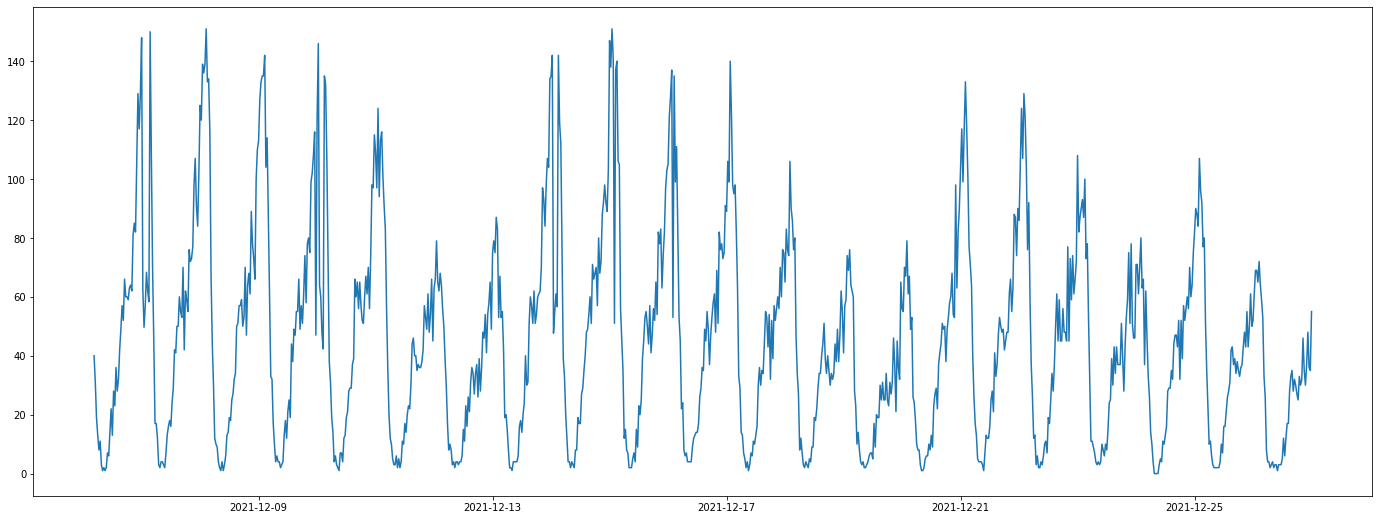

In [43]:
f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_store1.iloc[-1000:].index, df_store1['q_current'].iloc[-1000:])

## TRAIN, TEST SPLIT

##### Ussually here is used the test_train_split of sklearn module, but here the partitition should be temporal, where train data must be older than test data

In [ ]:
#For saving code, here is selected the segments where a model should be fitted

seleted_segment = 'store1'

if seleted_segment == 'store1':
    df_input = df_store1
if seleted_segment == 'store5':
    df_input = df_store5
if seleted_segment == 'store9':
    df_input = df_store9

In [13]:
# Split data set into train and test sets

train_size = int(len(df_input)*0.75)
test_size = len(df_input) - train_size

df_train, df_test = df_input.iloc[0:train_size,:], df_input.iloc[train_size:len(df_analysis),:]

print(df_train.shape)
print(min(df_train['date']))
print(max(df_train['date']))

print('\n')
print(df_test.shape)
print(min(df_test['date']))
print(max(df_test['date']))

(972, 7)
2021-11-30 00:30:00
2021-12-20 06:00:00


(324, 7)
2021-12-20 06:30:00
2021-12-27 00:00:00


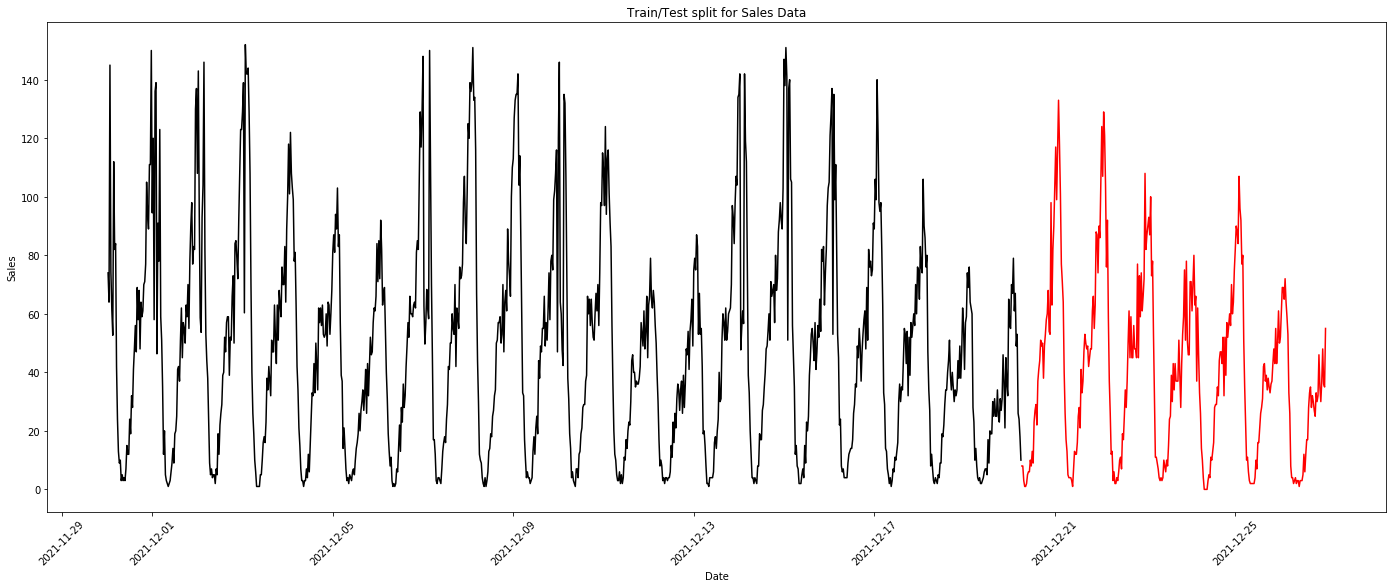

In [14]:
#Test and Train splits representation on time flow

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['q_current'], color = "black")
plt.plot(df_test['q_current'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")
plt.show()

# Time series model grid search

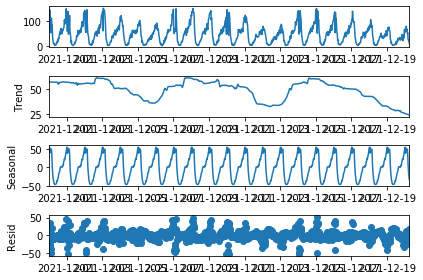

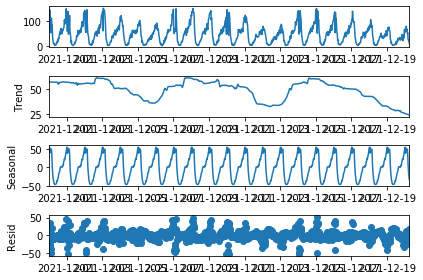

In [15]:
#Seasonal descomposition

decompose_data = seasonal_decompose(df_train[['q_current']], model="additive", extrapolate_trend='freq', period=48)

decompose_data.plot()

In [16]:
#Stacionarity test

dftest = adfuller(df_train['q_current'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.68354910410968
2. P-Value :  1.1869913963752225e-16
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 960
5. Critical Values :
	 1% :  -3.437180074590612
	 5% :  -2.8645553686071326
	 10% :  -2.5683755479600694


### Here can be observed stacionarity, it should be corrected, but for better manipulation, it will be opted for ARIMA model

In [ ]:
# SARIMA GRID SEARCH
# Define the p, d and q parameters for value between 0-3 and iterate for all the value in the range

if seleted_segment == 'store1':

    df_train_ = df_train.iloc[-500:,:] #amples the series to optimize the computations

    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q 
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
    params=[]
    seasonal=[]
    aic=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(df_train_['q_current'],
                                            order=param,
                                            seasonal_order=param_seasonal,                                    
                                            enforce_stationarity=False,                                          
                                            enforce_invertibility=False)

            #append all the parameters and result AIC value
            results = mod.fit()
            params.append(param)
            seasonal.append(param_seasonal)
            aic.append(results.aic)
            parameter_options=pd.DataFrame({'params':params,'seasonal_params':seasonal,'AIC':aic})

    #sort the AIC value to find the best fitted model
    parameter_options.sort_values(by='AIC')

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: 

In [35]:
#The lowest AIC to select the best ARIMAX order to model the time series

#(1, 0, 1)	(2, 1, 2, 24)	17196.063253

if seleted_segment == 'store1':

    parameter_options.to_pickle(OUTPUT_DIR + 'grid_parameter_options.pkl')
    print(parameter_options.shape)

    parameter_options.sort_values(by='AIC')

,params,seasonal_params,AIC
59,"(0, 0, 2)","(0, 1, 2, 12)",4092.195619
62,"(0, 0, 2)","(0, 2, 2, 12)",4103.905791
50,"(0, 0, 1)","(2, 1, 2, 12)",4148.774776
53,"(0, 0, 1)","(2, 2, 2, 12)",4187.490194
65,"(0, 0, 2)","(1, 0, 2, 12)",4204.197451
...,...,...,...
33,"(0, 0, 1)","(0, 2, 0, 12)",5177.124718
3,"(0, 0, 0)","(0, 1, 0, 12)",5198.153749
15,"(0, 0, 0)","(1, 2, 0, 12)",5265.372714
0,"(0, 0, 0)","(0, 0, 0, 12)",5462.636559


In [36]:
# Trainning the model with the best parameters observed in grid search

prediction=[]
my_order = (0, 0, 2)
my_seasonal_order = (0, 1, 2, 12)

initial=len(df_train)

model = sm.tsa.statespace.SARIMAX(df_train['q_current'], 
                                  order=my_order, 
                                  seasonal_order=my_seasonal_order)
results=model.fit()

print(results.summary().tables[1])

C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\willi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7353      0.020     36.850      0.000       0.696       0.774
ma.L2          0.5338      0.024     22.620      0.000       0.488       0.580
ma.S.L12      -1.1568      0.073    -15.812      0.000      -1.300      -1.013
ma.S.L24       0.1606      0.039      4.166      0.000       0.085       0.236
sigma2       461.0164     34.492     13.366      0.000     393.414     528.619


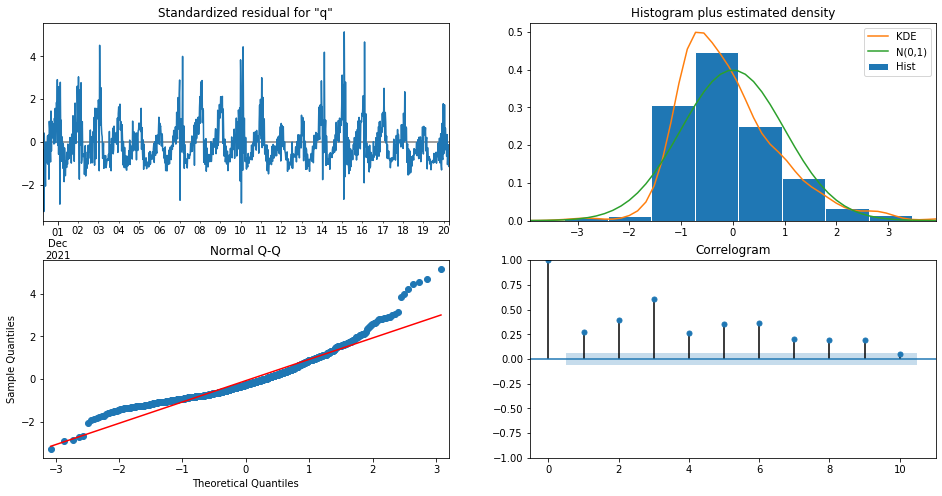

In [37]:
#Explore whether the error are randomly distributed along cero and  normal distributed
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [38]:
# Computes some performance metrics of the model in train set

df_train['prediction'] = results.predict()
df_train

print()
mse = mean_squared_error(df_train['q_current'], df_train['prediction'])
rmse = round(np.sqrt(mse),2)

print('rmse: ', rmse)
print('% r2: ', r2_score(df_train['q_current'], df_train['prediction']))


rmse:  23.91
% r2:  0.5788480478425241


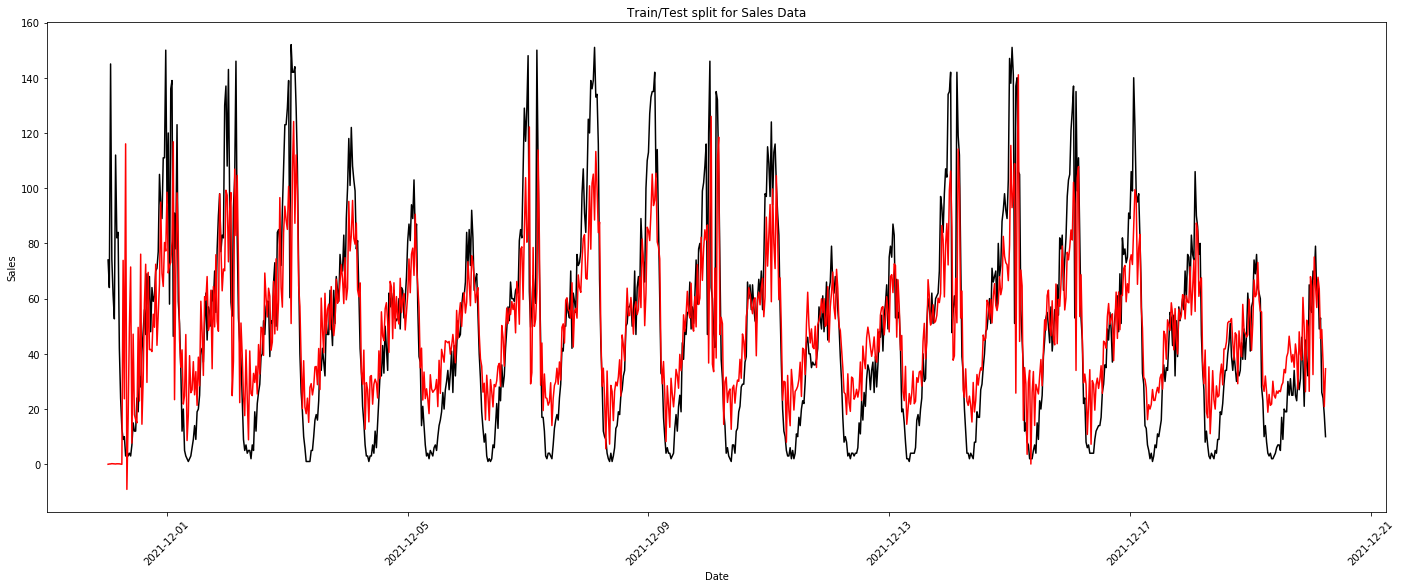

In [39]:
#Graphical comparison between real vs prediction for train set

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['q_current'], color = "black")
plt.plot(df_train['prediction'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")
plt.show()

In [40]:
# Computes some performance metrics of the model in test set

pred_uc = results.get_forecast(steps=len(df_test))
pred_ci = pred_uc.conf_int()

df_test['prediction'] = pred_uc.predicted_mean
df_test

target_decription = df_test['prediction'].describe()
print(target_decription)

mse = mean_squared_error(df_test['q_current'], df_test['prediction'])
rmse = round(np.sqrt(mse),2)
pp_error = rmse/target_decription['mean']

print('\n')
print('rmse: ', rmse)
print('% error: ', pp_error)
print('% r2: ', r2_score(df_test['q_current'], df_test['prediction']))


count    324.000000
mean      48.501314
std        4.156059
min       26.056656
25%       45.756390
50%       48.023912
75%       52.065897
max       57.170483
Name: prediction, dtype: float64


rmse:  31.26
% error:  0.6445186238652713
% r2:  -0.06810876474931282


### Looks at the rmse < std which indicates that the model is good enough
### Also the r2 is above 0.7
### The % error is not higher than 0.5

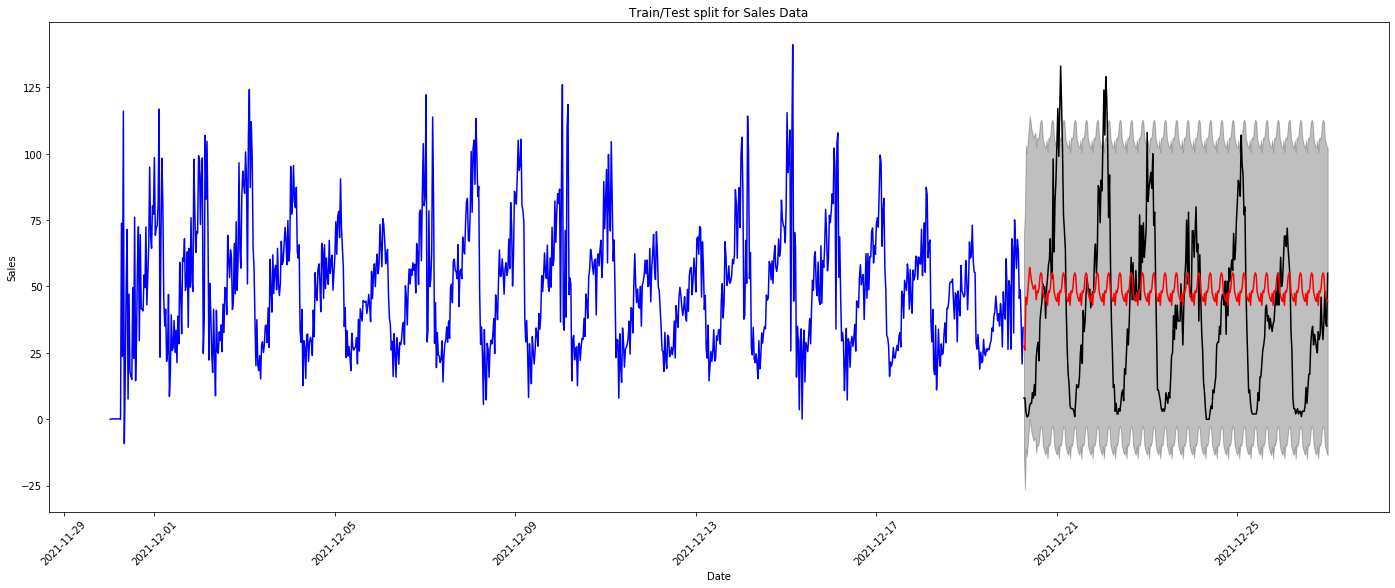

In [41]:
#Graphical comparison between real vs prediction for test set

f, ax = plt.subplots(figsize=(24,9))
plt.plot(df_train['prediction'], color = "blue")
plt.plot(df_test['q_current'], color = "black")
plt.plot(df_test['prediction'], color = "red")
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Sales Data")

ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.show()



In [ ]:
#Saves the total procedure for the choosen model

if seleted_segment == 'store1': 
    pickle.dump(results, open( OUTPUT_DIR + 'store1_sales_model.pkl', 'wb'))
    
if seleted_segment == 'store5': 
    pickle.dump(results, open( OUTPUT_DIR + 'store5_sales_model.pkl', 'wb'))
    
if seleted_segment == 'store8': 
    pickle.dump(results, open( OUTPUT_DIR + 'store9_sales_model.pkl', 'wb'))